# Graph Signal Processing Data Augmentation

In [1]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


# Step 1: Read in dataset

## Read in dataset - Coordinates System

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
print(os.getcwd())
os.chdir('../datasets/ntu_dataset')
print(os.getcwd())

/home/jovyan/committed_git/data_augmentation
/home/jovyan/committed_git/datasets/ntu_dataset


In [37]:
rp_np = np.loadtxt('label_cor.txt')
rp_np = np.unique(rp_np, axis = 0)

print(rp_np.shape)

(277, 2)


## Convert to x,y system

In [94]:
import math

def get_xycoords(origin_lat, origin_lon, rp_array):
    
    xy_coords = np.zeros((277,2), dtype = np.float64)
    cur_index = 0
    
    for rp in rp_array:
        
        lat, lon = rp[0], rp[1]
        # *1000 to convert from km to m
        dx = ((origin_lon - lon)*40000*math.cos((origin_lat+lat)*math.pi/360)/360)*1000 
        dy = ((origin_lat - lat)*40000/360)*1000    
        xy_coords[cur_index][0] = dx
        xy_coords[cur_index][1] = dy
        
        cur_index += 1
        
    return xy_coords

In [95]:
# Selecting rp with rp_index = 266 as the origin point (last point), calculate x,y coordinates of all other points from
# that origin
origin_lat, origin_lon = rp_np[266][0], rp_np[266][1]
xy_coords = get_xycoords(origin_lat, origin_lon, rp_np)

# Combine the lat, lon and x,y numpy arrays
rp_coords = np.concatenate((rp_np, xy_coords), axis = 1)
print(rp_coords.shape)

(277, 4)


In [96]:
rp_indexes = [i for i in range(len(rp_coords))]
rp_lat = rp_coords[:,0]
rp_long = rp_coords[:,1]
rp_x = rp_coords[:,2]
rp_y = rp_coords[:,3]

rp_data = {'rp_index': rp_indexes, 'rp_lat': rp_lat, 'rp_long': rp_long, 'rp_x': rp_x, 'rp_y': rp_y}
rp_df = pd.DataFrame(data = rp_data)

print(f'No. of total reference points: {len(rp_indexes)}')

No. of total reference points: 277


In [97]:
rp0_df = rp_df[(rp_df['rp_lat'] == 1.35487300000000) & (rp_df['rp_long'] == 103.688911000000)]
print(f'No. of repeated samples: {len(rp0_df)}')

No. of repeated samples: 1


In [98]:
rp_df.head(30)

,rp_index,rp_lat,rp_long,rp_x,rp_y
0,0,1.349733,103.685176,110.635844,571.111111
1,1,1.349733,103.685425,82.976883,571.111111
2,2,1.349733,103.685674,55.317922,571.111111
3,3,1.349733,103.685923,27.658961,571.111111
4,4,1.349733,103.686172,0.000000,571.111111
5,5,1.349733,103.686421,-27.658961,571.111111
6,6,1.349733,103.686919,-82.976883,571.111111
7,7,1.349733,103.687168,-110.635844,571.111111
8,8,1.349733,103.687417,-138.294805,571.111111
9,9,1.349733,103.687666,-165.953766,571.111111


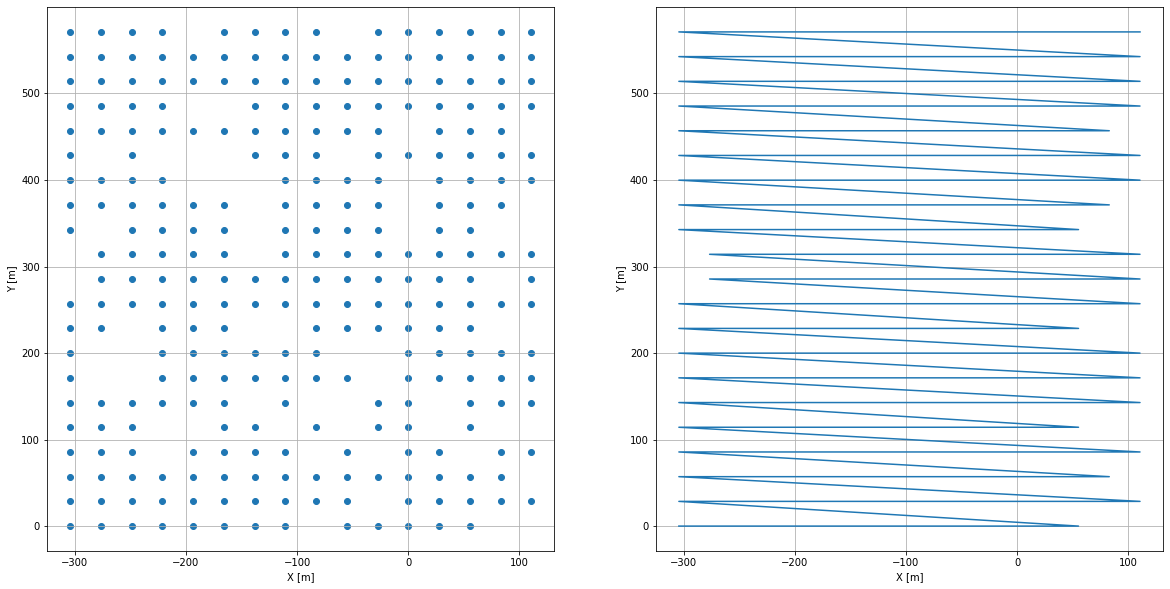

In [105]:
plt.rcParams['figure.figsize'] = [20, 10]

xs, ys = rp_df['rp_x'], rp_df['rp_y']
fig, ax = plt.subplots(1, 2)

ax[0].scatter(xs, ys)
ax[0].set_xlabel('X [m]')
ax[0].set_ylabel('Y [m]')
ax[0].grid()

ax[1].plot(xs, ys)
ax[1].set_xlabel('X [m]')
ax[1].set_ylabel('Y [m]')
ax[1].grid()

## Read in dataset - Signal Measurements Fingerprints

In [119]:
# Collect radio frequency measurements for each of the reference point and reformat it as 2D array
# Array structure:[[RSSI-1, TDoA-1], [RSSI-2, TDoA-2], ... , [RSSI-N,TDoA-N]] where N is the number of
# repeated samples taken at each reference point

# Read in each of the base station's data first
bs_137410 = np.loadtxt('cor137410.txt')
bs_143850 = np.loadtxt('cor143850.txt')
bs_144680 = np.loadtxt('cor144680.txt')
bs_734777 = np.loadtxt('cor734777.txt')
bs_734817 = np.loadtxt('cor734817.txt')
bs_748823 = np.loadtxt('cor748823.txt')
bs_749197 = np.loadtxt('cor749197.txt')

basestations = [bs_137410, bs_143850, bs_144680, bs_734777, bs_734817, bs_748823, bs_749197]

# Constants
num_rps = 277
num_samples = 100
num_bs = 7
num_featuresperbs = 2

# (277,100,14)
fp_array = np.zeros((277,100,14), dtype = np.float64)

for i in range(num_rps):
    
    cur_rp_measurements = []
    
    for j in range(num_bs):
        
        cur_bs = basestations[j]
        cur_rp_bs_measurements = cur_bs[i::num_rps]       
        
        rssi_samples, tdoa_samples = cur_rp_bs_measurements[:,0], cur_rp_bs_measurements[:,1]
        cur_rp_measurements.append(rssi_samples)
        cur_rp_measurements.append(tdoa_samples)
        
    cur_rp_measurements = np.array(cur_rp_measurements)
    cur_rp_measurements = cur_rp_measurements.T

    fp_array[i] = cur_rp_measurements

print(fp_array.shape)

(277, 100, 14)


In [120]:
print(fp_array.T.shape)

(14, 100, 277)


# Step 2: Generate virtual RPs

# Step 3: Combine real + virtual RP and make a undirectional, weighted, fully connected graph

# Step 4: Create vector to represent each vertice(rp) in the graph - Node Embedding

# Step 5: Find out degree matrix D and adjacency matrix W

# Step 6: Get Graph Laplacian Matrix L

# Step 7: Solve spatial smoothness problem to find values for virtual RPs